In [1]:
from sklearn.preprocessing import  MinMaxScaler, StandardScaler , RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import optuna
import lightgbm as lgb

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
df.drop(['customerID','Churn',],axis=1).nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
dtype: int64

In [6]:
df = df.drop('customerID',axis=1)

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [8]:
cols_to_dummies = df.drop('Churn',axis=1).select_dtypes('object').columns
cols_to_dummies

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [9]:
df = pd.get_dummies(data=df,columns=cols_to_dummies, drop_first=True,dtype=int)

In [10]:
from scipy.stats import skew, kurtosis

numeric_cols = df.select_dtypes(include=['float', 'int']).columns
non_numeric_cols = df.select_dtypes(exclude=['float', 'int']).columns
num_df = df[numeric_cols]


skewness = num_df.apply(skew)
kurt = num_df.apply(kurtosis)

print("Skewness:\n",skewness)
print("Kurtosis:\n",kurt)

Skewness:
 SeniorCitizen                            1.833242
tenure                                   0.239489
MonthlyCharges                          -0.220477
TotalCharges                             0.963029
gender_Male                             -0.019027
Partner_Yes                              0.067908
Dependents_Yes                           0.875012
PhoneService_Yes                        -2.726572
MultipleLines_No phone service           2.726572
MultipleLines_Yes                        0.316543
InternetService_Fiber optic              0.243442
InternetService_No                       1.375476
OnlineSecurity_No internet service       1.375476
OnlineSecurity_Yes                       0.943521
OnlineBackup_No internet service         1.375476
OnlineBackup_Yes                         0.652678
DeviceProtection_No internet service     1.375476
DeviceProtection_Yes                     0.657310
TechSupport_No internet service          1.375476
TechSupport_Yes                        

<AxesSubplot:>

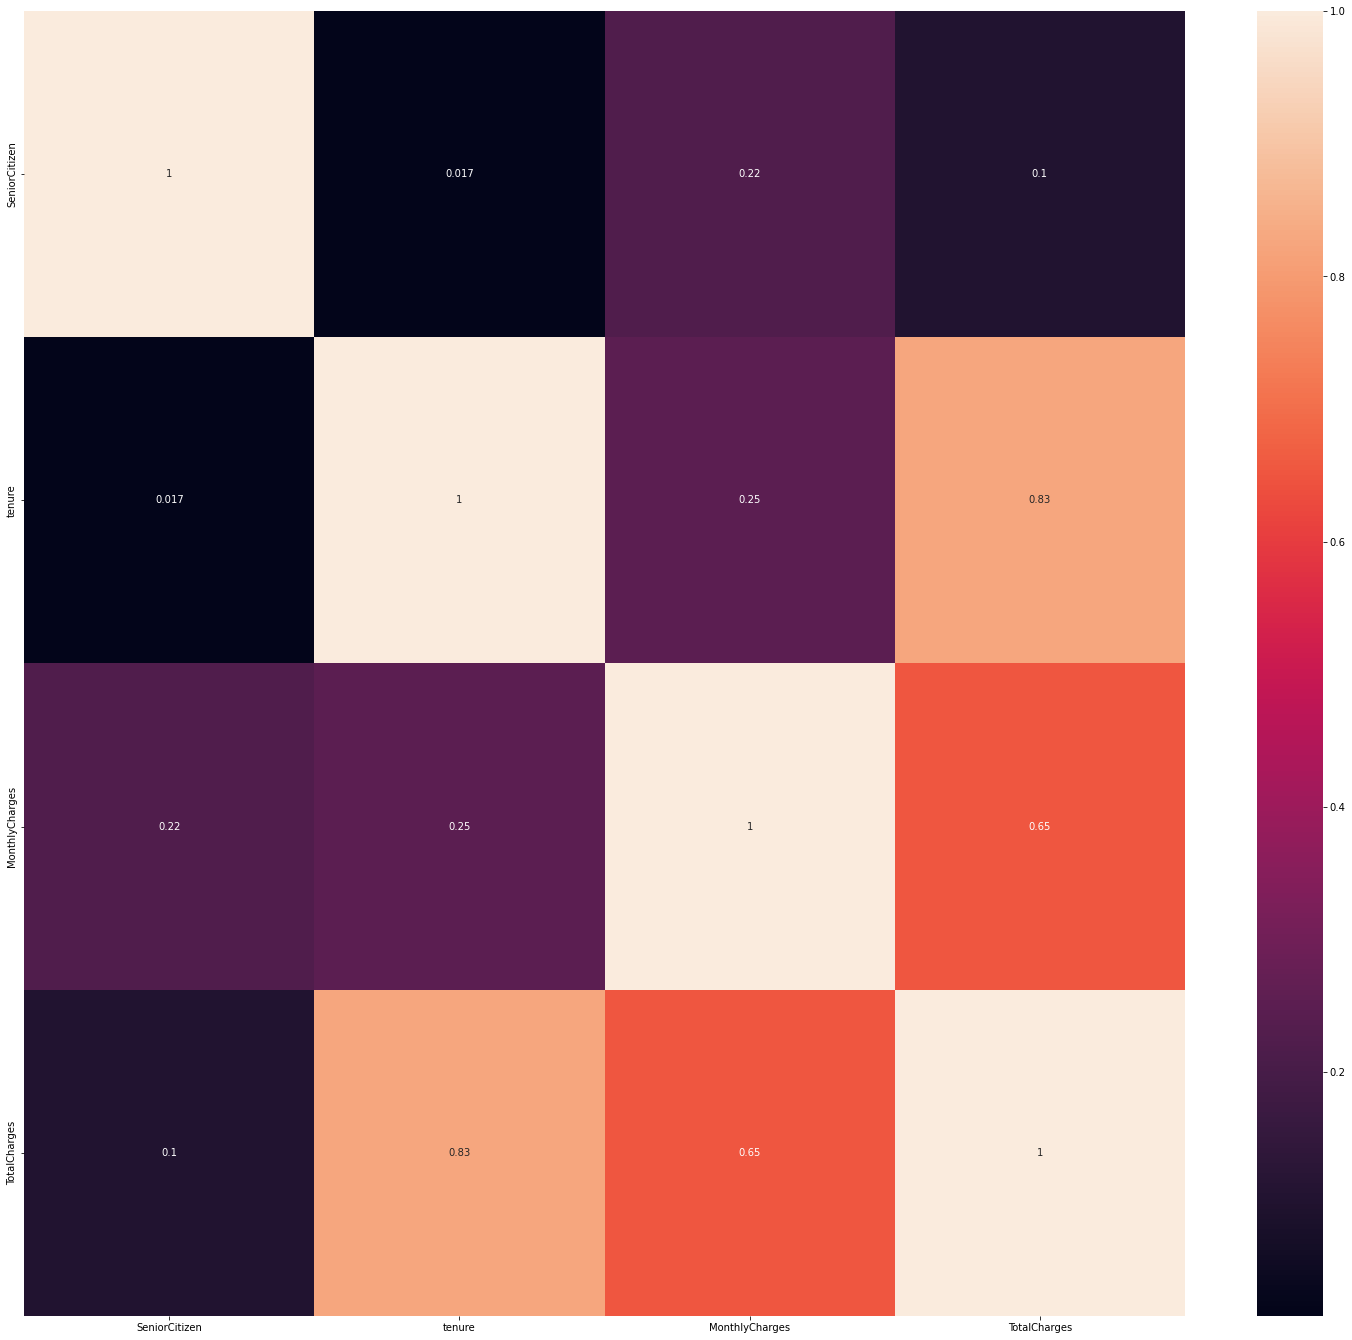

In [11]:
plt.figure(figsize=(26,24))
sns.heatmap(df.select_dtypes(['int64','float64']).corr(),annot=True) 

In [12]:
from imblearn.under_sampling import TomekLinks

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

def log_transform(X):
    return np.log1p(X)

pipeline = Pipeline([
    ('minmax_scale', MinMaxScaler()),
    ('log_transform', FunctionTransformer(log_transform))
])

In [14]:
def tomek_links (X,y) : 
    
    tl = TomekLinks(sampling_strategy='auto')

    X_resampled, y_resampled = tl.fit_resample(X, y)
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)
    
    return X_resampled , y_resampled

In [15]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn',axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Before TOMEK Shape=',len(X_train))
print(y_train.value_counts())

Before TOMEK Shape= 4930
No     3635
Yes    1295
Name: Churn, dtype: int64


In [16]:
X_train, y_train = tomek_links (X,y)

In [17]:
map_ = {'Yes':1,'No':0}
y_train = y_train.map(map_)
y_test = y_test.map(map_)

In [18]:
print('After TOMEK Shape=',len(X_train))
y_train.value_counts()

After TOMEK Shape= 9206


0    4603
1    4603
Name: Churn, dtype: int64

In [19]:
X_train_log = pipeline.fit_transform(X_train)
X_test_log = pipeline.transform(X_test)

In [20]:
X_train_log

array([[0.        , 0.01379332, 0.1092336 , ..., 0.        , 0.69314718,
        0.        ],
       [0.        , 0.38677298, 0.32575402, ..., 0.        , 0.        ,
        0.69314718],
       [0.        , 0.02739897, 0.30323218, ..., 0.        , 0.        ,
        0.69314718],
       ...,
       [0.        , 0.01379332, 0.50683809, ..., 0.        , 0.69314718,
        0.        ],
       [0.        , 0.189242  , 0.5802436 , ..., 0.        , 0.69314718,
        0.        ],
       [0.        , 0.01379332, 0.41536385, ..., 0.        , 0.        ,
        0.69314718]])

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score

logmodel = LogisticRegression(solver='lbfgs', max_iter=1000)
logmodel.fit(X_train_log, y_train)
predictions_log = logmodel.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_log)
print('log_r roc_auc(log): ',roc_auc)

log_r roc_auc(log):  0.8487920342862575


In [22]:
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(logmodel, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.92202863 0.92447399 0.91847001 0.91867651 0.9233998 ]


In [23]:
from lightgbm import LGBMClassifier

In [24]:
lgbm_params_1 = {'n_estimators': 661, 'max_depth': 240, 'learning_rate': 0.05494948704979913, 
                 'reg_alpha': 0.005325802880645769, 'reg_lambda': 0.25928395623872597, 
                 'min_child_weight': 0.7581321965742767, 'min_child_samples': 17,
                 'subsample': 0.7232041763778796, 'subsample_freq': 1, 
                 'colsample_bytree': 0.4521807761795655, 'num_leaves': 204,"verbosity":-1}

lgbm_classifier_1 = LGBMClassifier(**lgbm_params_1, random_state=42,)
lgbm_classifier_1.fit(X_train_log,y_train)
predictions_lgbm_1 = lgbm_classifier_1.predict_proba(X_test_log)[:, 1]
roc_auc = roc_auc_score(y_test,predictions_lgbm_1)
print('lgbm roc_auc: ',roc_auc) 

lgbm roc_auc:  0.9874120712802784


In [25]:
# Check column names of input data
print("Input Data Columns:", df.columns)

# Check column names of training data
print("Training Data Columns:", X_train.columns)


Input Data Columns: Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')
Training Data Columns: Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       '

In [26]:
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgbm_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.93644276 0.93088708 0.93035598 0.92540043 0.93534318]


In [27]:
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [28]:
predictions_lgbm_ = (predictions_lgbm_1 > 0.7).astype(int)
class_report_lgbm = classification_report(y_test, predictions_lgbm_)
print("Classification Report:")
print(class_report_lgbm)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1539
           1       0.91      0.98      0.94       574

    accuracy                           0.97      2113
   macro avg       0.95      0.97      0.96      2113
weighted avg       0.97      0.97      0.97      2113



In [29]:
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgbm_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.93644276 0.93088708 0.93035598 0.92540043 0.93534318]


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

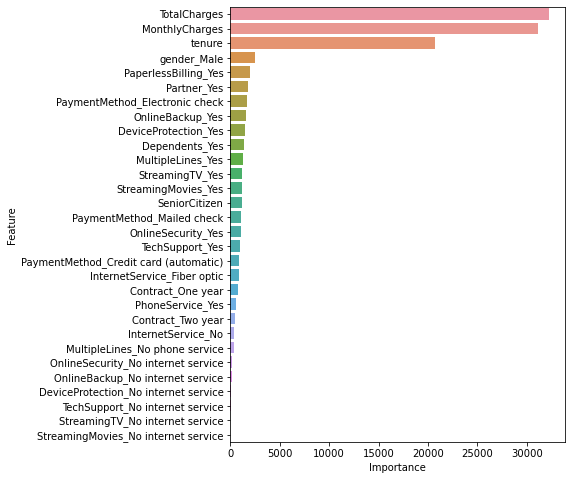

In [30]:
columns_pca = X_train.columns

feature_importance = lgbm_classifier_1.feature_importances_
feature_importance_df = pd.DataFrame({
   'Feature': columns_pca,  
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 8))
sns.barplot(y=feature_importance_df['Feature'],x=feature_importance_df['Importance'],data=feature_importance_df)

In [31]:
xgb_params_1 = {'n_estimators': 710, 'max_depth': 196, 'min_child_weight': 6.701183051451496, 
                'learning_rate': 0.026676087502806502, 'subsample': 0.8495695973697881, 
                'gamma': 0.6152593330262623, 'colsample_bytree': 0.38222797489425975, 
                'colsample_bylevel': 0.357244623613023, 'colsample_bynode': 0.792490975286392, 
                'reg_alpha': 0.5812620866048983, 'reg_lambda': 0.37030134449615004, 
                'scale_pos_weight': 0.6040507737125296, 'max_delta_step': 16.87096589724198, 
                'min_split_loss': 0.5400536255411681, 'lambda': 0.44693587004990476, 
                'alpha': 0.019312448258408388}
xgb_classifier_1 = XGBClassifier(**xgb_params_1,random_state=42)
xgb_classifier_1.fit(X_train_log,y_train)
predictions_xgb = xgb_classifier_1.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_lgbm_1)
print('xgb roc_auc: ',roc_auc) 

xgb roc_auc:  0.9874120712802784


In [32]:
predictions_xgb_ = (predictions_xgb > 0.7).astype(int)
class_report_xgb = classification_report(y_test, predictions_xgb_)
print("Classification Report:")
print(class_report_xgb)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1539
           1       0.77      0.40      0.52       574

    accuracy                           0.80      2113
   macro avg       0.79      0.68      0.70      2113
weighted avg       0.80      0.80      0.78      2113



In [33]:
cv_scores = cross_val_score(lgbm_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.93644276 0.93088708 0.93035598 0.92540043 0.93534318]


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

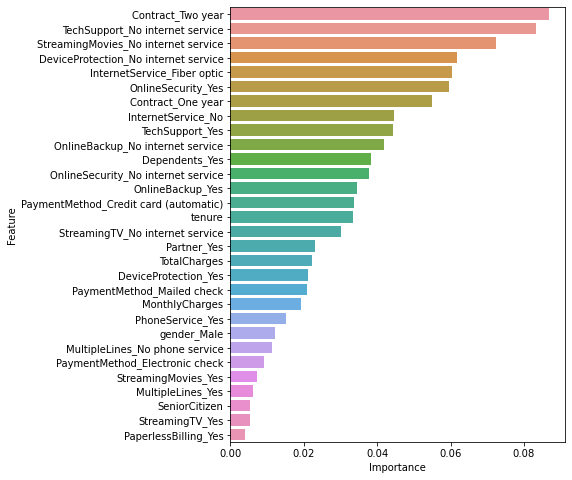

In [34]:
columns_pca = X_train.columns

feature_importance = xgb_classifier_1.feature_importances_
feature_importance_df = pd.DataFrame({
   'Feature': columns_pca,  
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 8))
sns.barplot(y=feature_importance_df['Feature'],x=feature_importance_df['Importance'],data=feature_importance_df)

In [35]:
from catboost import CatBoostClassifier
cat_boost_params_1 = {'iterations': 189, 'depth': 6, 'learning_rate': 0.03120170252537937, 
                      'l2_leaf_reg': 7.354377590658675, 'border_count': 147, 'bagging_temperature': 0.9939238676926005,
                      'random_strength': 0.7519139939927411,
                      'scale_pos_weight': 89.38778661423312, 'min_data_in_leaf': 20, 'grow_policy': 'Lossguide'}

catb_classifier_1 = CatBoostClassifier(**cat_boost_params_1 , random_state=42, logging_level='Silent')
catb_classifier_1.fit(X_train_log, y_train)
predictions_catb = catb_classifier_1.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_catb)
print('catb roc_auc: ',roc_auc) 

catb roc_auc:  0.8597368534253429


In [36]:
predictions_catb_ = (predictions_catb > 0.95).astype(int)
class_report_catb = classification_report(y_test, predictions_catb_)
print("Classification Report:")
print(class_report_catb)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.52      0.67      1539
           1       0.42      0.95      0.58       574

    accuracy                           0.63      2113
   macro avg       0.69      0.73      0.63      2113
weighted avg       0.82      0.63      0.65      2113



In [37]:
cv_scores = cross_val_score(catb_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.91463089 0.91232437 0.9068793  0.9055457  0.91417044]


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

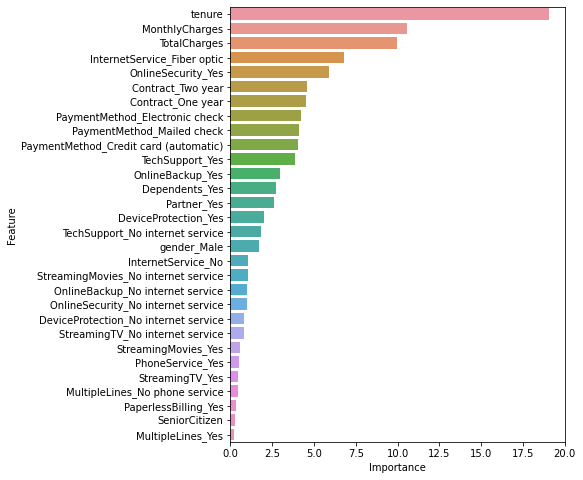

In [38]:
columns_pca = X_train.columns

feature_importance = catb_classifier_1.feature_importances_
feature_importance_df = pd.DataFrame({
   'Feature': columns_pca,  
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 8))
sns.barplot(y=feature_importance_df['Feature'],x=feature_importance_df['Importance'],data=feature_importance_df)

In [39]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_params_1 = {'learning_rate': 0.07658122403991667, 'max_iter': 759, 'max_leaf_nodes': 42, 'max_depth': 16, 
                 'min_samples_leaf': 8, 'l2_regularization': 0.5547180338955557, 'max_bins': 151}
hist_classifier_1 = HistGradientBoostingClassifier(**hist_params_1 , random_state=42,)
hist_classifier_1.fit(X_train_log, y_train)
predictions_hist = hist_classifier_1.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_hist)
print('catb roc_auc: ',roc_auc) 

catb roc_auc:  0.9880058094649452


In [40]:
cv_scores = cross_val_score(hist_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.93322676 0.93111614 0.92673651 0.92729907 0.93480368]


In [41]:
predictions_hist_ = (predictions_hist > 0.5).astype(int)
class_report_hist = classification_report(y_test, predictions_hist_)
print("Classification Report:")
print(class_report_hist)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1539
           1       0.87      0.99      0.93       574

    accuracy                           0.96      2113
   macro avg       0.93      0.97      0.95      2113
weighted avg       0.96      0.96      0.96      2113



In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=8,
    p=3
)
knn.fit(X_train_log, y_train)
predictions_knn = knn.predict_proba(X_test_log)[:,1]
roc_auc_knn = roc_auc_score(y_test,predictions_knn)
print('roc_auc knn', roc_auc_knn)

roc_auc knn 0.8763994448632874


In [43]:
cv_scores = cross_val_score(knn, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.89606277 0.89406983 0.88925792 0.89286737 0.90280906]


In [44]:
predictions_knn_ = (predictions_knn > 0.6).astype(int)
class_report_knn = classification_report(y_test, predictions_knn_)
print("Classification Report:")
print(class_report_knn)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1539
           1       0.59      0.78      0.67       574

    accuracy                           0.79      2113
   macro avg       0.75      0.79      0.76      2113
weighted avg       0.82      0.79      0.80      2113



In [45]:
from sklearn.ensemble import RandomForestClassifier


rf_params_1 = {'n_estimators': 53, 'max_depth': 30, 'min_samples_split': 2,
               'min_samples_leaf': 1, 'max_features': 0.10243605101760357}

rf_classifier_1 = RandomForestClassifier(**rf_params_1 , random_state=42,)
rf_classifier_1.fit(X_train_log, y_train)
predictions_rf = rf_classifier_1.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_rf)
print('randomforest roc_auc: ',roc_auc)

randomforest roc_auc:  0.9890998951760612


In [46]:
cv_scores = cross_val_score(rf_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.9304836  0.92627164 0.92376428 0.92140677 0.93268641]


In [47]:
predictions_rf_ = (predictions_rf > 0.6).astype(int)
class_report_rf = classification_report(y_test, predictions_rf_)
print("Classification Report:")
print(class_report_rf)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1539
           1       0.91      0.98      0.94       574

    accuracy                           0.97      2113
   macro avg       0.95      0.97      0.96      2113
weighted avg       0.97      0.97      0.97      2113



In [48]:
from sklearn.ensemble import VotingClassifier

model1 = xgb_classifier_1
model2 = lgbm_classifier_1
model3 = logmodel
model4 = hist_classifier_1
model5 = rf_classifier_1
model6 = knn
model7 = catb_classifier_1

ensemble_model = VotingClassifier(estimators=
                                  [
#                                               ('model1', model1),
                                              ('model2', model2),
#                                               ('model3', model3),
                                              ('model4', model4),
                                              ('model5', model5),
#                                               ('model6', model6),
#                                               ("model7", model7)
                                             ], 
                                  
                                  voting='soft')

In [49]:
ensemble_model.fit(X_train_log,y_train)
ensemble_predictions = ensemble_model.predict_proba(X_test_log)[:, 1]
roc_auc = roc_auc_score(y_test,ensemble_predictions)
print('Ensemble roc_auc: ',roc_auc) 

Ensemble roc_auc:  0.9907101765253241


In [50]:
ensemble_predictions_soft = (ensemble_predictions > 0.75).astype(int)
ensemble_predictions_soft_class_report_ = classification_report(y_test, ensemble_predictions_soft)
print("Classification Report:\n")
print(ensemble_predictions_soft_class_report_)

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1539
           1       0.93      0.96      0.95       574

    accuracy                           0.97      2113
   macro avg       0.96      0.97      0.96      2113
weighted avg       0.97      0.97      0.97      2113



In [51]:
from joblib import dump

# Assuming your RFC model is named 'rfc_model'
dump(ensemble_model, 'Churn_model.joblib')

['Churn_model.joblib']